# imports

In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

from NDNT.utils import imagesc   # because I'm lazy
import ColorDataUtils.mattplotlib as mplt
from ColorDataUtils.multidata_utils import MultiExperiment

class Model:
    def __init__(self, ndn_model, LLs):
        self.ndn = ndn_model
        self.LLs = LLs
from models import iter_core

device = torch.device("cuda:1")

datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/'

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils


# load data

In [2]:
num_lags=16
expt_names = ['J220715']#,'J220722','J220801','J220808']
array_types = ['UT']#, 'UT', 'UT', 'UT']
expts = MultiExperiment(expt_names)
data, drift_terms, mu0s = expts.load(datadir,
                                     num_lags=num_lags,
                                     et_metric_thresh=0.8,
                                     array_types=array_types,
                                     luminance_only=True,
                                     build_stim=False)

  FILE_INFO: stim_locsLP list again -- ok but output check
167520 total time steps, 239 units
J220715 68.5% fixations remaining


# LGN filters

0.028281411


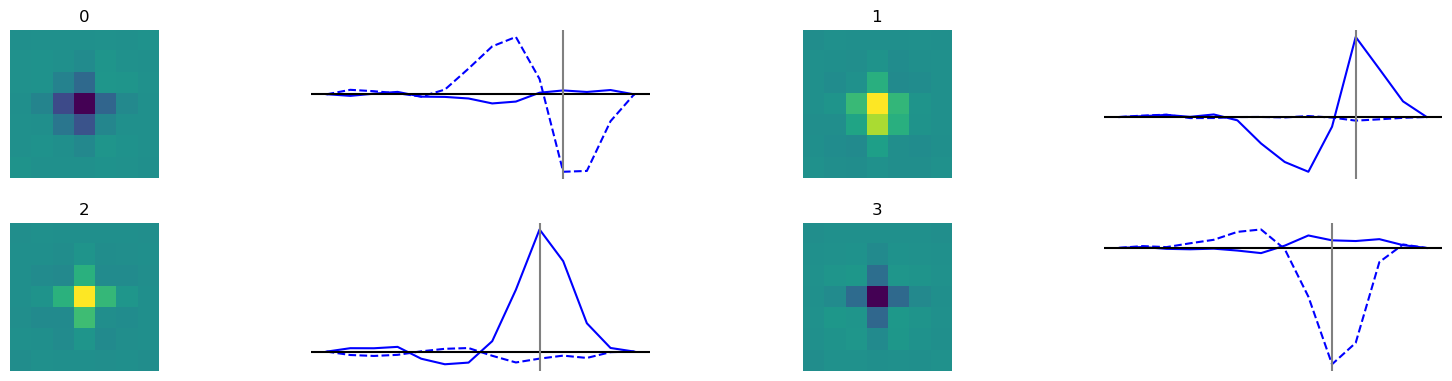

In [3]:
print(np.mean(iter_core.LLs))
iter_core.ndn_model.plot_filters()

# plot proj filters

In [ ]:
iter_core.ndn_model.networks[0].layers[1].get_weights().shape

In [6]:
fig = plt.figure(figsize=(15,50))
grid = matplotlib.gridspec.GridSpec(23, 8, wspace=0.1, hspace=0.1)
for idx in range(45*4):
    i,j = np.unravel_index(idx,(45,4)) # layer position
    row,col = np.unravel_index(idx,(23,8)) # plot position
    ax = plt.subplot(grid[row,col])
    proj_filter = iter_core.ndn_model.networks[0].layers[1].get_weights()[j,:,:,i].reshape((15,15))
    imagesc(proj_filter, ax=ax)

Error in callback <function _draw_all_if_interactive at 0x7fb0bd8f5580> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fafe33d5da0> (for post_execute):



KeyboardInterrupt



# cluster the proj filters

In [7]:
from copy import deepcopy
proj_filters = deepcopy(iter_core.ndn_model.networks[0].layers[1].get_weights())
print(proj_filters.shape)
proj_filters = np.swapaxes(proj_filters, 3,1)
proj_filters = np.swapaxes(proj_filters, 3,2)
proj_filters = np.reshape(proj_filters, (
    proj_filters.shape[0]*proj_filters.shape[1],
    proj_filters.shape[2]*proj_filters.shape[3]))
    #proj_filters.shape[2],proj_filters.shape[3]))
print(proj_filters.shape)

(4, 15, 15, 45)
(180, 225)


## UMAP clustering

In [8]:
# cluster the filters with HDBSCAN
import hdbscan
from sklearn.datasets import make_blobs
blobs, labels = make_blobs(n_samples=2000, n_features=10)
clusterer = hdbscan.HDBSCAN()
clusterer.fit(blobs)

HDBSCAN()

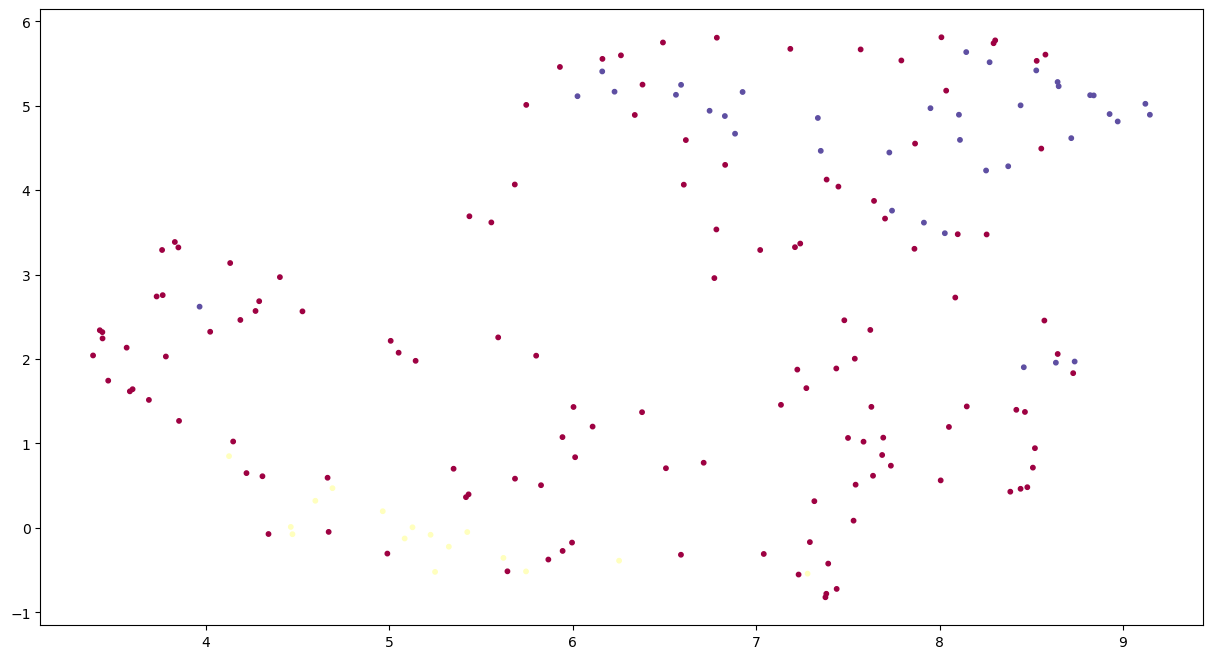

In [14]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=10, metric='correlation')
clusterer.fit(proj_filters)

# display the filters with UMAP
import umap
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='correlation')
embedding = reducer.fit_transform(proj_filters)

# plot the embedding
fig = plt.figure(figsize=(15,8))
plt.scatter(embedding[:,0], embedding[:,1], s=10, c=clusterer.labels_, cmap='Spectral')
plt.show()

## hierarichal clustering (BAD)

In [ ]:
# class _Leaf(object):
#     def __init__(self, filter):
#         self.filter = filter
# 
# class _Cluster(object):
#     def __init__(self, distance, children):
#         self.distance = distance
#         self.children = children
#         self.filters = []
# 
#     def get_filters(self):
#         # populate the filters array if it is empty
#         if len(self.filters) == 0:
#             for child in self.children:
#                 if isinstance(child, _Leaf):
#                     self.filters.append(child.filter)
#                 else:
#                     self.filters.extend(child.get_filters())
#         return self.filters
# 
# 
# # create a proper tree structure,
# # where each node has the average distance of its children
# def convert_to_tree(pairs, filters):
#     leaves = {}
#     clusters = {}
# 
#     for i, row in enumerate(pairs):
#         if row[0] < len(filters):
#             # if it is an original point read it from the centers array
#             a = filters[int(row[0])]
#             a = _Leaf(a)
#             leaves[row[0]] = a
#         else:
#             # other wise read the cluster that has been created
#             a = clusters[int(row[0])]
# 
#         if row[1] < len(filters):
#             b = filters[int(row[1])]
#             b = _Leaf(b)
#             leaves[row[1]] = b
#         else:
#             b = clusters[int(row[1])]
# 
#         # set a and b as children of the new node
#         distance = row[2]
#         cluster = _Cluster(distance, children=[a, b])
# 
#         clusters[1 + i + len(pairs)] = cluster
#     return clusters
# from scipy.cluster import hierarchy
# # cluster the proj_filters
# 
# # make a distance matrix between the neurons based on their weights
# dists = np.zeros((proj_filters.shape[0], proj_filters.shape[0]))
# for i in range(proj_filters.shape[0]):
#     for j in range(proj_filters.shape[0]):
#         dists[i,j] = np.corrcoef(proj_filters[i], proj_filters[j])[0,1]
# 
# Z = hierarchy.linkage(dists, 'single')
# fig = plt.figure(figsize=(25, 10))
# dn = hierarchy.dendrogram(Z)
# 
# clusters = convert_to_tree(Z, proj_filters)
# 
# for i,cluster in enumerate(clusters.values()):
#     num_filters = len(cluster.get_filters())
#     num_rows = num_filters//8 + 1
#     num_cols = min(num_filters, 8)
#     fig = plt.figure(figsize=(10,10))
#     grid = matplotlib.gridspec.GridSpec(nrows=num_rows,
#                                         ncols=num_cols)
#     for j, filter in enumerate(cluster.get_filters()):
#         print(filter.shape)
#         row,col = np.unravel_index(j, (num_rows, num_cols))
#         ax = plt.subplot(grid[row,col])
#         imagesc(filter, ax=ax)
#     plt.show()